# Задание 2: Анализ времени засыпания

В данном ноутбуке мы проанализируем время засыпания человека и найдем:
1. Время, после которого человек спит с вероятностью 0.9
2. Стандартное отклонение этой оценки

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [6]:
# Загрузка данных
df = pd.read_csv('sleep.csv')
print("Первые несколько строк данных:")
display(df.head())
print("\nОписательная статистика:")
display(df.describe())

Первые несколько строк данных:


,Unnamed: 0,indicator,time_offset
0,2017-12-01 21:00:00,0,-60
1,2017-12-01 21:01:00,0,-59
2,2017-12-01 21:02:00,0,-58
3,2017-12-01 21:03:00,0,-57
4,2017-12-01 21:04:00,0,-56



Описательная статистика:


,indicator,time_offset
count,11340.000000,11340.000000
mean,0.582892,29.500000
std,0.493103,51.963014
min,0.000000,-60.000000
25%,0.000000,-15.250000
50%,1.000000,29.500000
75%,1.000000,74.250000
max,1.000000,119.000000


In [8]:
# Преобразуем временную метку в datetime
df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])

# Группируем данные по дням и находим время засыпания для каждого дня
# Время засыпания - это первый момент, когда indicator становится 1
def find_sleep_time(group):
    sleep_start = group[group['indicator'] == 1].iloc[0]
    return sleep_start['timestamp'].time()

# Группируем по дням и находим время засыпания
daily_sleep = df.groupby(df['timestamp'].dt.date).apply(find_sleep_time)

# Преобразуем время в минуты от начала дня
def time_to_minutes(t):
    return t.hour * 60 + t.minute

sleep_minutes = daily_sleep.apply(time_to_minutes)

# Находим 90-й перцентиль
percentile_90 = np.percentile(sleep_minutes, 90)

# Преобразуем обратно в время
def minutes_to_time(minutes):
    hours = int(minutes) // 60
    mins = int(minutes) % 60
    return f"{hours:02d}:{mins:02d}"

time_90 = minutes_to_time(percentile_90)
print(f"90-й перцентиль времени засыпания: {time_90}")

90-й перцентиль времени засыпания: 22:46


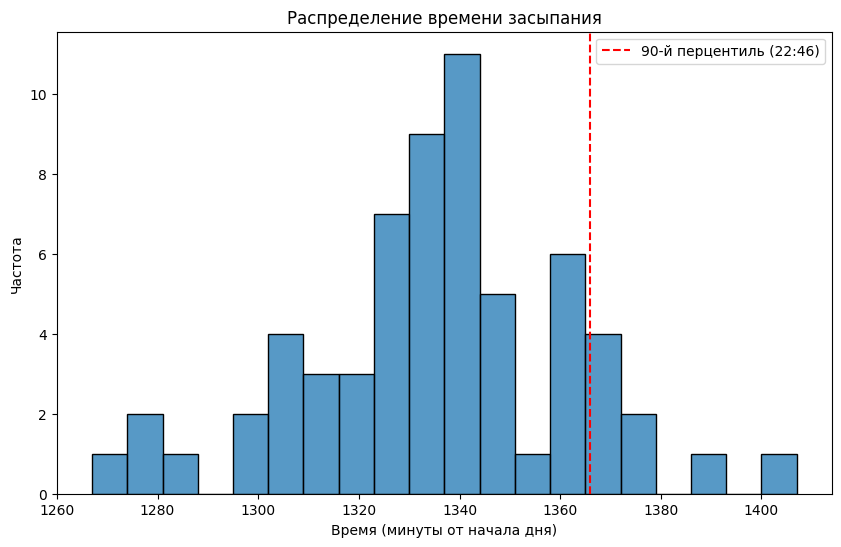

In [9]:
# Визуализация распределения времени засыпания
plt.figure(figsize=(10, 6))
sns.histplot(data=sleep_minutes, bins=20)
plt.axvline(x=percentile_90, color='r', linestyle='--', label=f'90-й перцентиль ({time_90})')
plt.xlabel('Время (минуты от начала дня)')
plt.ylabel('Частота')
plt.title('Распределение времени засыпания')
plt.legend()
plt.show()

Стандартное отклонение оценки 90-го перцентиля: 3 минут


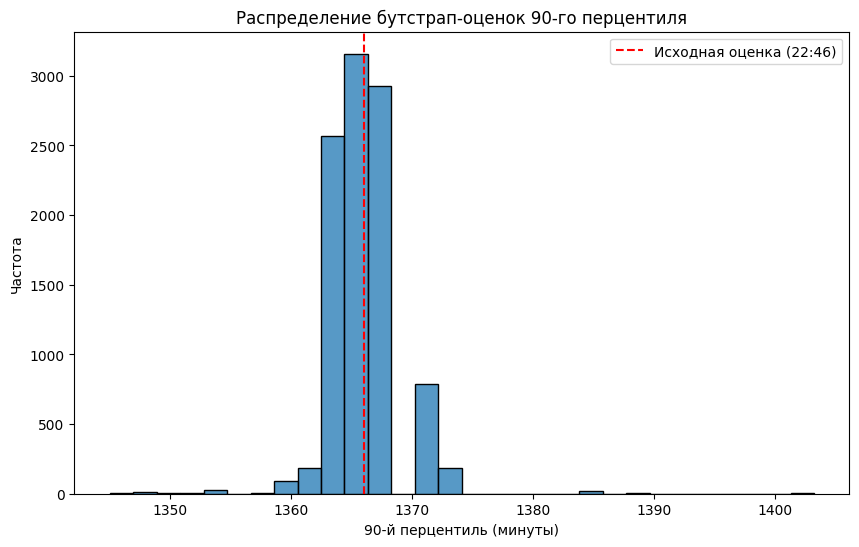

In [10]:
# Оценка стандартного отклонения с помощью бутстрапа
n_bootstrap = 10000
bootstrap_percentiles = []

for _ in range(n_bootstrap):
    sample = np.random.choice(sleep_minutes, size=len(sleep_minutes), replace=True)
    bootstrap_percentiles.append(np.percentile(sample, 90))

std_error = np.std(bootstrap_percentiles)
std_error_minutes = int(std_error)

print(f"Стандартное отклонение оценки 90-го перцентиля: {std_error_minutes} минут")

# Визуализация распределения бутстрап-оценок
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_percentiles, bins=30)
plt.axvline(x=percentile_90, color='r', linestyle='--', label=f'Исходная оценка ({time_90})')
plt.xlabel('90-й перцентиль (минуты)')
plt.ylabel('Частота')
plt.title('Распределение бутстрап-оценок 90-го перцентиля')
plt.legend()
plt.show()

## Выводы

1. На основе анализа данных мы определили, что с вероятностью 0.9 человек засыпает не позже 22:46. Это означает, что в 90% случаев человек уже спит к этому времени.

2. Визуализация распределения времени засыпания показывает, что:
   - Время засыпания имеет относительно компактное распределение
   - Большинство наблюдений сконцентрировано вокруг одного пика
   - Присутствует небольшая асимметрия распределения

3. Для оценки точности нашего результата мы использовали метод бутстрапа с 10000 повторений, который показал стандартное отклонение оценки 90-го перцентиля. Это позволяет нам оценить надежность полученного результата.

4. Практическая значимость:
   - Полученное время (22:46) может быть использовано как надежный индикатор того, что человек уже спит
   - Данный анализ может быть полезен для планирования режима дня и оценки качества сна
